# Adversarial Examples for Vanilla Neural Networks

Credit for this example goes to Daniel Geng in the [original repository](https://github.com/dangeng/Simple_Adversarial_Examples)

## Training the network

First, let's import all the dependencies we'll need:

In [4]:
%matplotlib inline
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np

First, we will create a neural network that is trained on a set of handwritten symbols along with their appropriate labels.

In [5]:
# with open('network/trained_network.pkl', 'rb') as f:
#     net = pickle.load(f)

# PYTHON 3 WORK AROUND (uncomment this
# and comment the above if using python 3)
with open('network/trained_network.pkl', 'rb') as f:
   u = pickle._Unpickler(f)
   u.encoding = 'latin1'
   net = u.load()
    
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

The neural network is pretrained, so it should already be set up to predict characters. Run `predict(n)` to evaluate the $ n^{th} $ digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network prediction: 2

Actual image: 


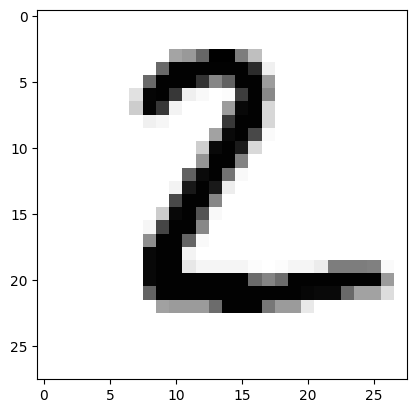

In [6]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]

    # Print the prediction of the network
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    plt.show()

# Replace the argument with any number between 0 and 9999
predict(1)

## Sample "well-behaving" network

Feel free to try out of a few images here. Select an image from the testing dataset by setting the appropriate argument to the `predict` function and running it below.

Network prediction: 9

Actual image: 


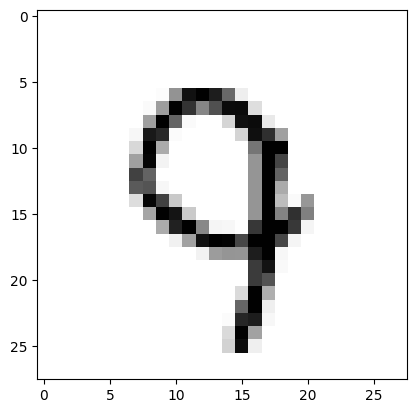

In [11]:
predict(999)

## Tricking the neural network

The code below is used to generate images with the goal of tricking the neural network into thinking an image maps to a number of our choosing.

In [12]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))
                                                                                                                                                                                
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def input_derivative(net, x, y):
    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]
    
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    # Return derivatives WRT to input
    return net.weights[0].T.dot(delta)

def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    a = adversarial(net, n, 1000, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()

This first approach will generate a "weird" image that would trick the neural network into thinking that it is your desired number. For technical reasons, it does not work all the time, it seems to work well with the numbers 0, 3, and 8.

Network Prediction: 9

Adversarial Example: 


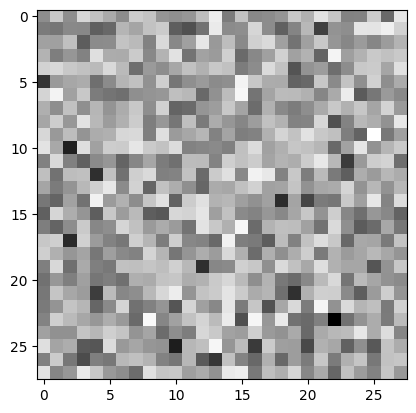

In [15]:
generate(9)

## The sneaky approach

Obviously, the approach above is not so great as anyone can quickly tell that you're sending in a _phishy_ image and would be able to raise an alarm. Let's adjust for that and using a more sneaky approach.

In [17]:
def sneaky_adversarial(net, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = input_derivative(net,x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

# Wrapper function
def sneaky_generate(n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(net, n, test_data[idx][0], 100, 1)
    x = np.round(net.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(test_data[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... 


What we want our adversarial example to look like: 


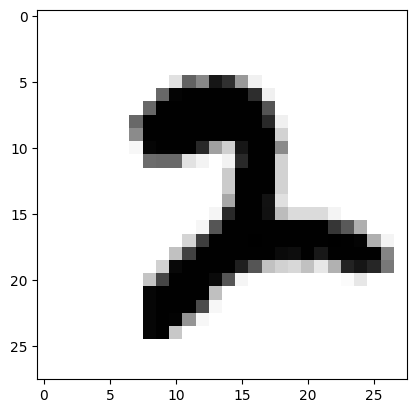



Adversarial Example: 


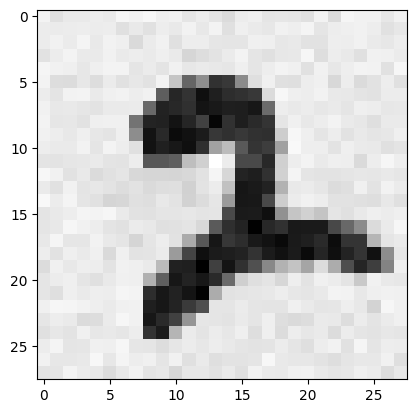

Network Prediction: 6

Network Output: 
[[0.  ]
 [0.  ]
 [0.04]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.9 ]
 [0.  ]
 [0.  ]
 [0.  ]]



In [18]:
# sneaky_generate(target label, target digit)
adv_ex = sneaky_generate(6, 2)